# Fit Models on Different Samples With Resampling Ensembles

Ensemble learning are methods that combine the predictions from multiple models. It is important in ensemble learning that the ensemble models are good, making different prediction errors. Predictions that are good in different ways can result in a prediction that is both more stable and often better than the predictions of any individual member model. One way to achieve differences between models is to train each model on a different subset of the available training data. Models are trained on different subsets of the training data naturally through resampling methods such as cross-validation and the bootstrap, designed to estimate the average performance of the model generally on unseen data. The models used in this estimation process can be combined in what is referred to as a resampling-based ensemble, such as a cross-validation ensemble or a bootstrap aggregation (or bagging) ensemble. In this tutorial, you will discover how to develop a suite of different resampling-based ensembles for deep learning neural network models. After completing this tutorial, you will know:

* How to estimate model performance using random splits and develop an ensemble from the models.
* How to estimate performance using 10-fold cross-validation and develop a cross-validation ensemble.
* How to estimate performance using the bootstrap and combine models using a bagging ensemble.

## Resampling Ensembles

Combining the predictions from multiple models can result in more stable predictions, and in some cases, predictions that have better performance than any of the contributing models. Effective ensembles require members that disagree. Each member must have the skill (e.g., perform better than random chance), but ideally, perform well in different ways. Technically, we can say that we prefer ensemble members to have low correlation in their predictions or prediction errors.

One approach to encourage differences between ensembles is to use the same learning algorithm on different training datasets. This can be achieved by repeatedly resampling a training dataset that is in turn used to train a new model. Multiple models are fit using slightly different perspectives on the training data and, in turn, make different errors and often more stable and better predictions when combined. We can refer to these methods generally as data resampling ensembles. A benefit of this approach is that resampling methods may be used that do not use all examples in the training dataset. Any examples that are not used to fit the model can be used as a test dataset to estimate the generalization error of the chosen model configuration. There are three popular resampling methods that we could use to create a resampling ensemble; they are:

* **Random Splits**. The dataset is repeatedly sampled with a random split of the data into train and test sets.
* **k-fold Cross-Validation**. The dataset is split into k equally sized folds, k models are trained, and each fold is given an opportunity to be used as the holdout set where the model is trained on all remaining folds.
* **Bootstrap Aggregation**. Random samples are collected with replacement, and examples not included in a given sample are used as the test set.

Perhaps the most widely used resampling ensemble method is bootstrap aggregation, more commonly referred to as bagging. The resampling with replacement allows more difference in the training dataset, biasing the model and, in turn, resulting in more difference between the predictions of the resulting models. Resampling ensemble models make some specific assumptions about your project:

* A robust estimate of model performance on unseen data is required; if not, then a single train/test split can be used.
* There is a potential for a lift in performance using an ensemble of models; if not, then a single model fit on all available data can be used.
* The computational cost of fitting more than one neural network model on a sample of the training dataset is not prohibitive; if not, all resources should be put into fitting a single model.

Neural network models are remarkably flexible, therefore the lift in performance provided by a resampling ensemble is not always possible given that individual models trained on all available data can perform so well. As such, the sweet spot for using a resampling ensemble is the case where there is a requirement for a robust estimate of performance, and multiple models can be fit to calculate the estimate, but there is also a requirement for one (or more) of the models created during the estimate of performance to be used as the final model (e.g., a new final model cannot be fit on all available training data). Now that we are familiar with resampling ensemble methods, we can work through an example of applying each method in turn.

## Resampling Ensembles Case Study

In this section, we will demonstrate how to use the resampling ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the resampling ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a model resampling ensembles. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same 1,000 points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

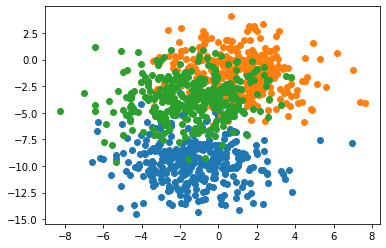

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Single Multilayer Perceptron Model

We will define a Multilayer Perceptron neural network or MLP that learns the problem reasonably well. The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

Next, we must split the dataset into training and test sets. We will use the test set both to evaluate the model's performance and to plot its performance during training with a learning curve. We will use 90% of the data for training and 10% for the test set. We are choosing a large split because it is a noisy problem and a well-performing model requires as much data as possible to learn the complex classification function.

In [4]:
# split into train and test
n_train = int(0.9 * X.shape[0])

trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 50 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 50 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=1)

Epoch 1/50
29/29 [==============================] - 1s 11ms/step - loss: 1.0301 - accuracy: 0.4089 - val_loss: 0.7700 - val_accuracy: 0.5700
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7876 - accuracy: 0.5897 - val_loss: 0.6653 - val_accuracy: 0.7500
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7407 - accuracy: 0.6478 - val_loss: 0.5953 - val_accuracy: 0.7600
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.6756 - val_loss: 0.5517 - val_accuracy: 0.7900
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6416 - accuracy: 0.7060 - val_loss: 0.5229 - val_accuracy: 0.8100
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.7276 - val_loss: 0.4911 - val_accuracy: 0.8100
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6175 - accuracy: 0.7146 - val_loss: 0.4788 - val_accuracy: 0.8500
Epoch 8/50
29/29 [=

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [7]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.824, Test: 0.870


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

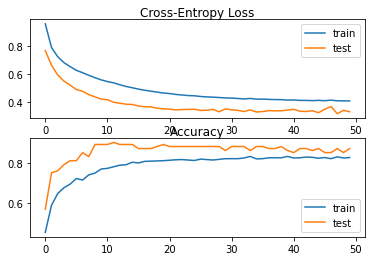

In [8]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [9]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.828, Test: 0.860


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 83% accuracy on the training dataset and about 86% on the test dataset. The chosen split of the dataset into train and test sets means that the test set is small and not representative of the broader problem. In turn, performance on the test set is not representative of the model; in this case, it is optimistically biased.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that the model has a reasonably stable fit.

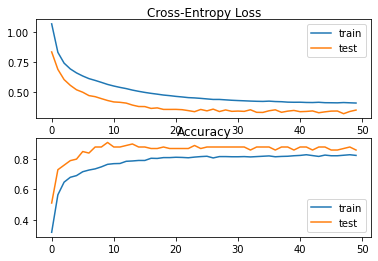

In [10]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### Random Splits Ensemble

The instability of the model and the small test dataset means that we do not know how well this model will perform on new data in general. We can try a simple resampling method of repeatedly generating new random splits of the dataset in train and test sets and fits new models. Calculating the average of the model's performance across each split will better estimate the model's generalization error. We can then combine multiple models trained on the random splits to expect the ensemble's performance to be more stable and better than the average single model. 

We will generate ten times more sample points from the problem domain and hold them back as an unseen dataset. The evaluation of a model on this much larger dataset will be used as a proxy or a much more accurate estimate of the generalization error of a model for this problem. This extra dataset is not a test dataset. Technically, it is for this demonstration, but we pretend that this data is unavailable at model training time.

In [11]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

So now we have 5,000 examples of training our model and estimating its general performance. We also have 50,000 examples that we can use to better approximate the true general performance of a single model or an ensemble. Next, we need a function to fit and evaluate a single model on a training dataset and return the performance of the fit model on a test dataset. We also need the model that was fit to use as part of an ensemble. The `evaluate_model()` function below implements this behavior.

In [12]:
# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
    # encode targets
    trainy_enc = to_categorical(trainy)
    testy_enc = to_categorical(testy)

    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=50, verbose=0)
    
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
    
    return model, test_acc

Next, we can create random splits of the training dataset and fit and evaluate models on each split. We can use the `train_test_split()` function from the scikit-learn library to randomly split a dataset into train and test sets. It takes the X and y arrays as arguments and the `test_size` specifies the size of the test dataset in terms of a percentage. We will use 10% of the 5,000 examples as the test. We can then call the `evaluate_model()` to fit and evaluate a model. The returned accuracy and model can then be added to lists for later use. In this example, we will limit the number of splits and fit models to 10.

In [15]:
from sklearn.model_selection import train_test_split

# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # split data
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
    
    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

>0.820
>0.802
>0.822
>0.838
>0.800
>0.816
>0.848
>0.822
>0.828
>0.810


After fitting and evaluating the models, we can estimate the expected performance of a given model with the chosen configuration for the domain.

In [18]:
from numpy import mean, std

# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

Estimated Accuracy 0.821 (0.014)


We do not know how many of the models will be useful in the ensemble. There will likely be a point of diminishing returns, after which the addition of further members no longer changes the ensemble's performance. Nevertheless, we can evaluate different ensemble sizes from 1 to 10 and plot their performance on the unseen holdout dataset. We can also evaluate each model on the holdout dataset and calculate the average of these scores to get a much better approximation of the true performance of the chosen model on the prediction problem.

In [24]:
from sklearn.metrics import accuracy_score
from numpy import array, argmax
import numpy

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, newX, newy)
    newy_enc = to_categorical(newy)
    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

> 1: single=0.821, ensemble=0.821
> 2: single=0.820, ensemble=0.821
> 3: single=0.820, ensemble=0.821
> 4: single=0.818, ensemble=0.821
> 5: single=0.819, ensemble=0.821
> 6: single=0.819, ensemble=0.821
> 7: single=0.820, ensemble=0.821
> 8: single=0.820, ensemble=0.820
> 9: single=0.820, ensemble=0.821
> 10: single=0.819, ensemble=0.820


Finally, we can compare and calculate a more robust estimate of the general performance of an average model on the prediction problem, then plot the performance of the ensemble size to accuracy on the holdout dataset.

Accuracy 0.820 (0.001)


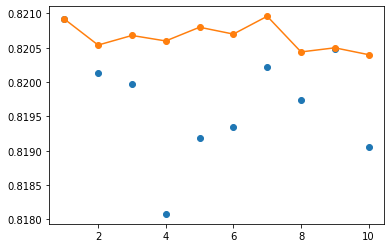

In [25]:
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

Tying all of this together, the complete example is listed below.

In [26]:
# random-splits mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy import mean, std, array, argmax
import numpy
from matplotlib import pyplot

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
    # encode targets
    trainy_enc = to_categorical(trainy)
    testy_enc = to_categorical(testy)

    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=50, verbose=0)

    # evaluate the model
    _, test_acc = model.evaluate(testX, testy_enc, verbose=0)

    return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    
    # argmax across classes
    result = argmax(summed, axis=1)

    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    
    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

Running the example first fits and evaluates ten models on ten different random splits of the dataset into train and test sets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

From these scores, we estimate that the average model fit on the dataset will achieve an accuracy of about 83% with a standard deviation of about 1.9%.

In [27]:
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # split data
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
    
    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.842
>0.850
>0.790
>0.824
>0.828
>0.824
>0.802
>0.820
>0.834
>0.842
Estimated Accuracy 0.826 (0.018)


We then evaluate the performance of each model on the unseen dataset and the performance of ensembles of models from 1 to 10 models. From these scores, we can see that a more accurate estimate of the performance of an average model on this problem is about 82% and that the estimated performance is optimistic.

In [28]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, newX, newy)
    newy_enc = to_categorical(newy)
    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.819, ensemble=0.819
> 2: single=0.820, ensemble=0.820
> 3: single=0.817, ensemble=0.820
> 4: single=0.820, ensemble=0.820
> 5: single=0.821, ensemble=0.820
> 6: single=0.819, ensemble=0.820
> 7: single=0.820, ensemble=0.820
> 8: single=0.821, ensemble=0.820
> 9: single=0.820, ensemble=0.820
> 10: single=0.818, ensemble=0.820
Accuracy 0.819 (0.001)


A lot of the difference between the accuracy scores is happening in the fractions of a percent. A graph is created showing the accuracy of each model on the unseen holdout dataset as blue dots and the performance of an ensemble with a given number of members from 1-10 as an orange line and dots. We can see that using an ensemble of 4-to-8 members, at least, in this case, results in an accuracy that is better than most of the individual runs (the orange line is above many blue dots).

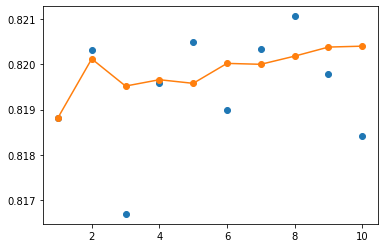

In [29]:
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

The graph shows that some individual models can perform better than an ensemble of models (blue dots above the orange line), but we cannot choose these models. Here, we demonstrate that without additional data (e.g., the out-of-sample dataset) that an ensemble of 4-to-8 members will give better on average performance than a randomly selected train-test model. More repeats (e.g., 30 or 100) may result in a more stable ensemble performance.

### Cross-Validation Ensemble

A problem with repeated random splits as a resampling method for estimating the average performance of the model is that it is optimistic. An approach designed to be less optimistic and is widely used as a result is the k-fold cross-validation method. The method is less biased because each example in the dataset is only used one time in the test dataset to estimate model performance, unlike random train-test splits where a given example may be used to evaluate a model many times. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. The average of the scores of each model provides a less biased estimate of model performance. A typical value for k is 10.

Because neural network models are computationally very expensive to train, it is common to use the best performing model during cross-validation as the final model. Alternately, the resulting models from the cross-validation process can be combined to provide a cross-validation
ensemble that is likely to have better performance on average than a given single model. We can use the KFold class from scikit-learn to split the dataset into k folds. It takes as arguments the number of splits, whether or not to shuffle the sample, and the seed for the pseudorandom
number generator used prior to the shuffle.

In [32]:
from sklearn.model_selection import KFold

# prepare the k-fold cross-validation configuration
n_folds = 10
kfold = KFold(n_folds, shuffle=True, random_state=1)

Once the class is instantiated, it can be enumerated to get each split of indexes into the dataset for the train and test sets.

In [33]:
# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]

    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)

    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

>0.826
>0.862
>0.810
>0.816
>0.832
>0.802
>0.816
>0.844
>0.810
>0.822


Once the scores are calculated on each fold, the average of the scores can be used to report the expected performance of the approach.

In [34]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

Estimated Accuracy 0.824 (0.017)


Now that we have collected the ten models evaluated on the ten folds, we can use them to create a cross-validation ensemble. It seems intuitive to use all ten models in the ensemble, nevertheless, we can evaluate the accuracy of each subset of ensembles from 1 to 10 members as we did in the previous section. The complete example of analyzing the cross-validation ensemble is listed below.

In [35]:
# cross-validation mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy import mean, std, array, argmax
import numpy

from matplotlib import pyplot

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
    # encode targets
    trainy_enc = to_categorical(trainy)
    testy_enc = to_categorical(testy)

    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=50, verbose=0)
    
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
    return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

# prepare the k-fold cross-validation configuration
n_folds = 10
kfold = KFold(n_folds, True, 1)

Running the example first prints the performance of each of the ten models on each of the folds of the cross-validation.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

The average performance of these models is reported as about 82%, which appears to be less optimistic than the random-splits approach used in the previous section.

In [36]:
# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]

    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.838
>0.866
>0.814
>0.808
>0.830
>0.808
>0.818
>0.840
>0.822
>0.814
Estimated Accuracy 0.826 (0.017)


Next, each of the saved models is evaluated on the unseen holdout set. The average of these scores is also about 82%, highlighting that, at least, in this case, the cross-validation estimation of the general performance of the model was reasonable.

In [37]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
    ensemble_score = evaluate_n_members(members, i, newX, newy)
    newy_enc = to_categorical(newy)
    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.820, ensemble=0.820
> 2: single=0.820, ensemble=0.820
> 3: single=0.820, ensemble=0.821
> 4: single=0.821, ensemble=0.821
> 5: single=0.820, ensemble=0.821
> 6: single=0.819, ensemble=0.820
> 7: single=0.821, ensemble=0.820
> 8: single=0.820, ensemble=0.820
> 9: single=0.820, ensemble=0.820
> 10: single=0.820, ensemble=0.820
Accuracy 0.820 (0.001)


A graph of single model accuracy (blue dots) and ensemble size vs. accuracy (orange line) is created. As in the previous example, the real difference between the performance of the models is in the fractions of a percent in model accuracy. The orange line shows that as the number of members increases, the accuracy of the ensemble increases to the point of diminishing returns. We can see that, at least in this case, using four or more of the models fit during cross-validation in an ensemble gives better performance than almost all individual models. We can also see that a default strategy of using all models in the ensemble would be effective.

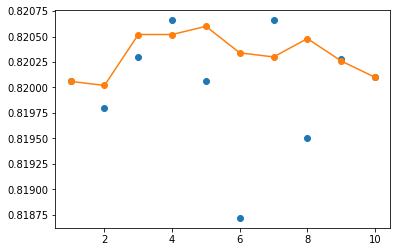

In [38]:
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

### Bagging Ensemble

A limitation of random splits and k-fold cross-validation from the perspective of ensemble learning is that the models are very similar. The bootstrap method is a statistical technique for estimating quantities about a population by averaging estimates from multiple small data samples. Importantly, samples are constructed by drawing observations from a large data sample one at a time and returning them to the data sample after they have been chosen. This allows a given observation to be included in a given small sample more than once. This approach to sampling is called sampling with replacement.

The method can be used to estimate the performance of neural network models. Examples not selected in a given sample can be used as a test set to estimate the model's performance. The bootstrap is a robust method for estimating model performance. It does suffer a little from an optimistic bias but is often almost as accurate as k-fold cross-validation in practice. The benefit for ensemble learning is that each data sample is biased, allowing a given example to appear many times in the sample. This, in turn, means that the models trained on those samples will be biased, importantly in different ways. The result can be an ensemble of predictions that can be more accurate.


Generally, the use of the bootstrap method in ensemble learning is referred to as bootstrap aggregation or bagging. We can use the resample() function from scikit-learn to select a subsample with replacement. The function takes an array to subsample, and the size of the resample as arguments. We will perform the selection in rows indices that we can in turn use to select rows in the X and y arrays. The sample size will be 4,500, or 90% of the data, although the test set may be larger than 10% as, given the use of resampling, more than 500 examples may have been left unselected.

In [40]:
from sklearn.utils import resample

# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=4500)
    test_ix = [x for x in ix if x not in train_ix]

    # select data
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]

    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

>0.832
>0.830
>0.820
>0.817
>0.839
>0.819
>0.845
>0.836
>0.813
>0.814


It is common to use simple overfit models like unpruned decision trees when using a bagging ensemble learning strategy (e.g., an ensemble averaging used to add bias to a suite of high variance models). Better performance may be seen with over-constrained and overfit neural networks. Nevertheless, we will use the same MLP from previous sections in this example. Additionally, it is common to continue to add ensemble members in bagging until the performance of the ensemble plateaus, as bagging does not overfit the dataset. We will again limit the number of members to 10, as in previous examples. The complete example of bootstrap aggregation for estimating model performance and ensemble learning with a Multilayer Perceptron is listed below.

In [42]:
# bagging mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy import mean, std, array, argmax
import numpy

from matplotlib import pyplot

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
    # encode targets
    trainy_enc = to_categorical(trainy)
    testy_enc = to_categorical(testy)

    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=50, verbose=0)
    
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
    
    return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)
    
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

Running the example prints the model performance on the unused examples for each bootstrap sample.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

We can see that, in this case, the expected performance of the model is less optimistic than random train-test splits and is perhaps quite similar to the finding for `k-fold` cross-validation.

In [43]:
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=4500)
    test_ix = [x for x in ix if x not in train_ix]

    # select data
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]

    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)

# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.831
>0.836
>0.819
>0.831
>0.816
>0.821
>0.810
>0.812
>0.817
>0.826
Estimated Accuracy 0.822 (0.008)


Perhaps due to the bootstrap sampling procedure, we see that the actual performance of each model is a little worse on the much larger unseen holdout dataset. This is to be expected given the bias introduced by the sampling with replacement of the bootstrap.

In [44]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, newX, newy)
    newy_enc = to_categorical(newy)
    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.820, ensemble=0.820
> 2: single=0.818, ensemble=0.820
> 3: single=0.820, ensemble=0.820
> 4: single=0.821, ensemble=0.820
> 5: single=0.821, ensemble=0.820
> 6: single=0.819, ensemble=0.820
> 7: single=0.818, ensemble=0.820
> 8: single=0.821, ensemble=0.820
> 9: single=0.815, ensemble=0.820
> 10: single=0.819, ensemble=0.821
Accuracy 0.819 (0.002)


The created line plot is encouraging. We see that after about four members that the bagged ensemble achieves better performance on the holdout dataset than any individual model. No doubt, given the slightly lower average performance of individual models.

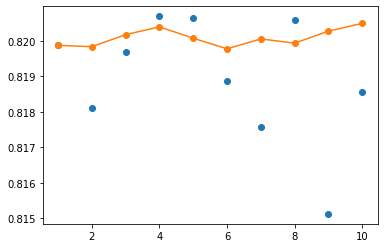

In [45]:
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Single Model**. Compare the performance of each ensemble to one model trained on all available data.
* **CV Ensemble Size**. Experiment with larger and smaller ensemble sizes for the cross-validation ensemble and compare their performance.
* **Bagging Ensemble Limit**. Increase the number of members in the bagging ensemble to find the point of diminishing returns.

## Summary

In this tutorial, you discovered how to develop a suite of different resampling-based ensembles for deep learning neural network models. Specifically, you learned:

* How to estimate model performance using random splits and develop an ensemble from the models.
* How to estimate performance using 10-fold cross-validation and develop a cross-validation ensemble.
* How to estimate performance using the bootstrap and combine models using a bagging ensemble.